In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Importa i dati

In [2]:
from src.load_data import get_epidemic_data, get_vaccine_data

### Dati relativi all'epidemia

In [3]:
df_epidemic = get_epidemic_data('Israel')
df_epidemic.head()

,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0


### Dati relativi alle vaccinazioni

In [4]:
df_vaccine = get_vaccine_data('Israel')
df_vaccine.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses
date,,
2020-12-21,0.37,0.0
2020-12-22,0.89,0.0
2020-12-23,1.61,0.0
2020-12-24,2.46,0.0
2020-12-25,2.90,0.0


### Unione dei due dataframes

In [5]:
df_merged = df_vaccine.join(df_epidemic,on=df_vaccine.index)
df_merged.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
date,,,,,,,,
2020-12-21,0.37,0.0,378259.0,26274.0,3111.0,348874.0,2679.0,15.3
2020-12-22,0.89,0.0,382487.0,28164.0,3136.0,351187.0,3122.4,17.4
2020-12-23,1.61,0.0,385022.0,29996.0,3150.0,351876.0,2854.3,16.6
2020-12-24,2.46,0.0,389678.0,31833.0,3171.0,354674.0,3100.4,17.3
2020-12-25,2.90,0.0,394391.0,33337.0,3186.0,357868.0,3462.7,18.4


# Fit del modello epidemiologico

In [6]:
from src.epi_model import SIR2
from src.optimizer import fit_model

In [7]:
# Il fit originario è stato fatto utilizzando i 28 giorni successivi 
# al 21 Dicembre (giorno di inizio delle vaccinazioni), 
# ossia prima che gli effetti delle vaccinazioni fossero visibili
tmax = 28 

# dati reali
ydata_casi = np.array(df_merged['Total cases'])[0:tmax]
ydata_inf = np.array(df_merged['Active infected'])[0:tmax]
ydata_rec = (np.array(df_merged['Total recovered'])+np.array(df_merged['Total deaths']))[0:tmax]

 
minpar = fit_model(y_data = [ydata_casi,ydata_inf,ydata_rec],
                   abitanti=8.84*10**6)

Optimization terminated successfully.
         Current function value: 1716.419134
         Iterations: 147
         Function evaluations: 264


In [8]:
beta = round(minpar[0],3)
gamma = round(minpar[1],3)
tau = round(minpar[2],1)

print('Parametri ottimizzati: beta',beta,'gamma',gamma,'tau',tau)

Parametri ottimizzati: beta 0.144 gamma 0.079 tau 123.7


In [14]:
abitanti_isr = 8.84*10**6

model_check = SIR2(abitanti_isr,minpar[0],minpar[1],minpar[2],
              vacc_eff=0,vacc_speed=0,t0=0,  
              I0=ydata_inf[0],R0=ydata_rec[0],V0=0)

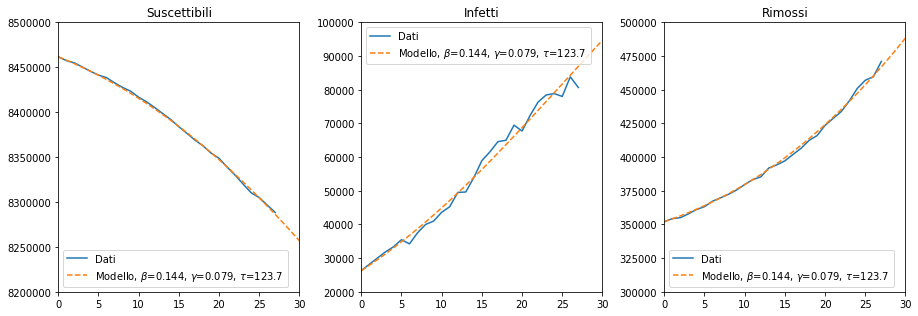

In [15]:
# check del modello, con curve di suscettibili, infetti e rimossi

plt.figure(figsize=(13,4.5))
plt.subplot(1,3,1)
plt.plot(abitanti_isr-ydata_casi,label='Dati')
plt.plot(model_check[1],
         linestyle='--',label='Modello, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,30)
plt.ylim(8.2*10**6,8.5*10**6)
plt.title('Suscettibili')
plt.legend()
plt.subplot(1,3,2)
plt.plot(ydata_inf,label='Dati')
plt.plot(model_check[2],
         linestyle='--',label='Modello, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,30)
plt.ylim(2*10**4,10*10**4)
plt.title('Infetti')
plt.legend()
plt.subplot(1,3,3)
plt.plot(ydata_rec,label='Dati')
plt.plot(model_check[3],
         linestyle='--',label='Modello, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,30)
plt.ylim(3*10**5,5*10**5)
plt.title('Rimossi')
plt.legend()
plt.tight_layout()
plt.savefig('results/check_model.png',dpi=300)
plt.show()

### previsioni del modello epidemiologico

In [17]:
# solo lockdown (vacc_speed= 0, beta, gamma, tau ricavati dal fit)
pred_lockdown=SIR2(abitanti_isr,minpar[0],minpar[1],minpar[2],
                   vacc_eff=0.95,vacc_speed = 0,t0=0,
                   I0=ydata_inf[0],R0=ydata_rec[0],V0=0)

# lockdown più vaccini (vacc_speed = 1.28, beta, gamma, tau ricavati dal fit)
# vacc_speed = 1.28 è un parametro di input del modello ed è legato alla velocità con cui vengono somministrate le vaccinazioni
# i vaccinati del modello devono coincidere con i vaccinati reali con doppia dose (vedi grafico in alto a destra nella sezione risultati)
# t0 = 21 indica il giorno di inizio di somministrazione delle 2° dosi
pred_lockdown_vaccine=SIR2(abitanti_isr,minpar[0],minpar[1],minpar[2],
                           vacc_eff=0.95,vacc_speed = 1.28,t0=21,
                           I0=ydata_inf[0],R0=ydata_rec[0],V0=0) 

# Risultati

In [18]:
# vaccinati con 1 dose e con 2 dosi
vaccinati_1dose = np.array(df_merged['% vaccinated with 1 dose'])
vaccinati_2dose = np.array(df_merged['% vaccinated with 2 doses'])

# incidenza settimanale ogni 100.000 abitanti
incidenza_settimanale = 7/(abitanti_isr/10**5)*np.array(df_merged['Daily cases (avg 7 days)'])

# decessi giornalieri per milione di abitanti
decessi_giornalieri = 1/(abitanti_isr/10**6)*np.array(df_merged['Daily deaths (avg 7 days)'])

# dati sugli infetti attivi
ydata_inf_complete = np.array(df_merged['Active infected'])

xticks_21 = ['21 Dic','4 Gen','18 Gen','1 Feb','15 Feb','1 Mar','15 Mar','29 Mar','12 Apr','26 Apr']

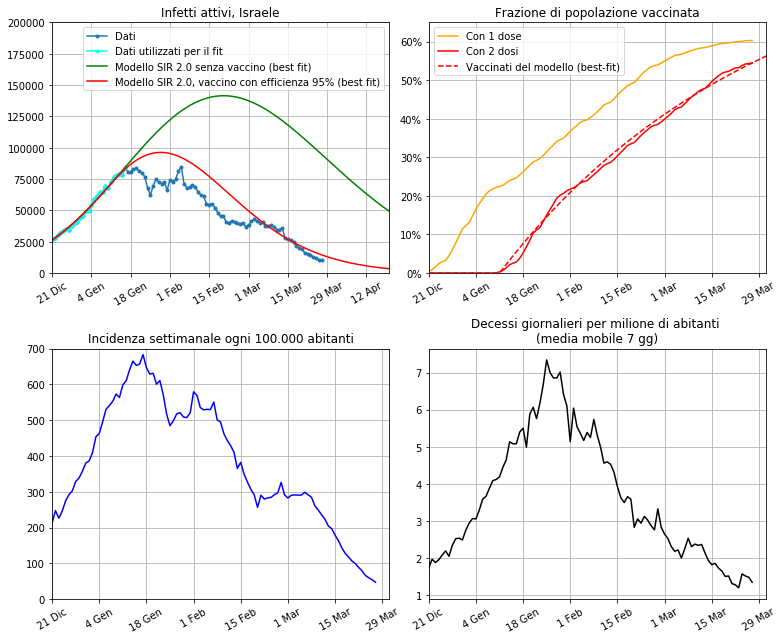

In [19]:
plt.figure(figsize=(11,9))
plt.subplot(2,2,1)
plt.plot(ydata_inf_complete,marker='.',label='Dati')
plt.plot(ydata_inf[0:27],marker='.',label='Dati utilizzati per il fit',color='cyan')
plt.plot(pred_lockdown[2],label='Modello SIR 2.0 senza vaccino (best fit)',color='green')
plt.plot(pred_lockdown_vaccine[2],label='Modello SIR 2.0, vaccino con efficienza 95% (best fit)',color='red')
plt.title('Infetti attivi, Israele')
plt.xticks(np.arange(0,120,14),xticks_21,rotation=30)
plt.xlim(0,120)
plt.ylim(0,2*10**5)
plt.grid()
plt.legend()
plt.subplot(2,2,2)
plt.title('Frazione di popolazione vaccinata')
plt.plot(vaccinati_1dose,label='Con 1 dose',color='orange')
plt.plot(vaccinati_2dose,label='Con 2 dosi',color='red')
plt.plot(pred_lockdown_vaccine[4]/(8.884*10**6)*100,label='Vaccinati del modello (best-fit)',color='red',linestyle='--')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.yticks(np.arange(0,111,10),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%','110%'])
plt.ylim(0,65)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.grid()
plt.legend()
plt.subplot(2,2,3)
plt.plot(incidenza_settimanale,color='blue')
plt.title('Incidenza settimanale ogni 100.000 abitanti')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.ylim(0,700)
plt.grid()
plt.subplot(2,2,4)
plt.plot(decessi_giornalieri,color='black')
plt.title('Decessi giornalieri per milione di abitanti \n(media mobile 7 gg)')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.grid()
plt.tight_layout()
plt.savefig('results/previsioni-israele.png',dpi=300)
plt.show()